In [1]:
# Importing general libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re
import time
from pprint import pprint
from collections import Counter

# Importing libraries for data processing
from nltk import FreqDist, word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Importing libraries for modeling
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Exploratory Data Analysis

In [2]:
# Data is splited already on train / test sets
train_heads = pd.read_csv('data\\train_stances.csv')
train_bodies = pd.read_csv('data\\train_bodies.csv')
test_heads = pd.read_csv('data\\competition_test_stances.csv')
test_bodies = pd.read_csv('data\\competition_test_bodies.csv')

### Investigating train set

In [3]:
train_heads.head()

,Headline,Body ID,Stance
0,Police find mass graves with at least '15 bodi...,712,unrelated
1,Hundreds of Palestinians flee floods in Gaza a...,158,agree
2,"Christian Bale passes on role of Steve Jobs, a...",137,unrelated
3,HBO and Apple in Talks for $15/Month Apple TV ...,1034,unrelated
4,Spider burrowed through tourist's stomach and ...,1923,disagree


In [4]:
train_heads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
Headline    49972 non-null object
Body ID     49972 non-null int64
Stance      49972 non-null object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
train_heads.Headline.describe()

count                                             49972
unique                                             1648
top       ISIL Beheads American Photojournalist in Iraq
freq                                                127
Name: Headline, dtype: object

In [6]:
len(set(train_heads['Body ID']))

1683

In [7]:
train_heads['Body ID'].value_counts()

1921    187
1948    175
40      172
524     171
1549    166
304     154
1385    151
125     145
2367    143
220     141
1438    141
195     140
2296    136
35      131
1786    131
1883    131
2520    127
1034    127
2252    126
1574    125
2307    125
527     125
2175    124
1627    123
2404    123
1289    122
2115    121
2096    120
1040    118
1893    117
       ... 
907       1
370       1
210       1
146       1
114       1
1542      1
63        1
76        1
390       1
515       1
193       1
464       1
355       1
323       1
624       1
282       1
18        1
797       1
701       1
362       1
2311      1
6         1
915       1
70        1
151       1
376       1
140       1
307       1
1066      1
59        1
Name: Body ID, Length: 1683, dtype: int64

In [8]:
train_bodies.head()

,Body ID,articleBody
0,0,A small meteorite crashed into a wooded area i...
1,4,Last week we hinted at what was to come as Ebo...
2,5,(NEWSER) – Wonder how long a Quarter Pounder w...
3,6,"Posting photos of a gun-toting child online, I..."
4,7,At least 25 suspected Boko Haram insurgents we...


In [9]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
Body ID        1683 non-null int64
articleBody    1683 non-null object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [10]:
train_bodies.articleBody.describe()

count                                                  1683
unique                                                 1669
top       A rumor on Tuesday claims Apple's upcoming App...
freq                                                      2
Name: articleBody, dtype: object

In [11]:
len(set(train_bodies['Body ID']))

1683

In [12]:
set(train_bodies['Body ID']) == set(train_heads['Body ID'])

True

### Investigating test set

In [13]:
test_heads.head()

,Headline,Body ID,Stance
0,Ferguson riots: Pregnant woman loses eye after...,2008,unrelated
1,Crazy Conservatives Are Sure a Gitmo Detainee ...,1550,unrelated
2,A Russian Guy Says His Justin Bieber Ringtone ...,2,unrelated
3,"Zombie Cat: Buried Kitty Believed Dead, Meows ...",1793,unrelated
4,Argentina's President Adopts Boy to End Werewo...,37,unrelated


In [14]:
test_heads.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25413 entries, 0 to 25412
Data columns (total 3 columns):
Headline    25413 non-null object
Body ID     25413 non-null int64
Stance      25413 non-null object
dtypes: int64(1), object(2)
memory usage: 595.7+ KB


In [15]:
test_heads.Headline.describe()

count                                           25413
unique                                            894
top       Source: Joan Rivers' doc did biopsy, selfie
freq                                              160
Name: Headline, dtype: object

In [16]:
len(set(test_heads['Body ID']))

904

In [17]:
test_heads['Body ID'].value_counts()

1373    161
2383    136
338     132
1639    123
1394    122
1765    119
2512    115
1454    110
2427    108
1275    103
1770    103
3       103
274     103
2233    102
535     101
2320    101
1272     98
2279     97
1431     97
1754     97
1386     94
934      93
2289     92
1326     91
1102     91
2491     90
2040     89
758      87
1886     87
1851     87
       ... 
590       1
66        1
857       1
310       1
770       1
278       1
102       1
642       1
64        1
270       1
1230      1
237       1
496       1
131       1
184       1
49        1
165       1
287       1
543       1
191       1
380       1
309       1
127       1
436       1
421       1
31        1
849       1
71        1
106       1
306       1
Name: Body ID, Length: 904, dtype: int64

In [18]:
test_bodies.head()

,Body ID,articleBody
0,1,Al-Sisi has denied Israeli reports stating tha...
1,2,A bereaved Afghan mother took revenge on the T...
2,3,CNBC is reporting Tesla has chosen Nevada as t...
3,12,A 4-inch version of the iPhone 6 is said to be...
4,19,GR editor’s Note\n\nThere are no reports in th...


In [19]:
test_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 2 columns):
Body ID        904 non-null int64
articleBody    904 non-null object
dtypes: int64(1), object(1)
memory usage: 14.2+ KB


In [20]:
test_bodies.articleBody.describe()

count                                                   904
unique                                                  900
top       A Grade 4 student was reportedly suspended fro...
freq                                                      2
Name: articleBody, dtype: object

In [21]:
len(set(test_bodies['Body ID']))

904

In [22]:
set(test_heads['Body ID']) == set(test_bodies['Body ID'])

True

### Counting the classes

In [23]:
def number_of_classes(dataframe, column='Stance'):
    no_stances = Counter(dataframe[column])
    stances_data = pd.DataFrame.from_dict(no_stances, orient='index')
    stances_data.columns = ['count']
    stances_data = stances_data.sort_values(['count'], ascending=False)
    total_no_counts = 0
    for index, row in stances_data.iterrows():
        total_no_counts += row['count']
    stances_data['%counts'] = round(stances_data['count']/total_no_counts*100)
    stances_data['count'].plot(kind='bar')
    print(stances_data)

           count  %counts
unrelated  36545     73.0
discuss     8909     18.0
agree       3678      7.0
disagree     840      2.0


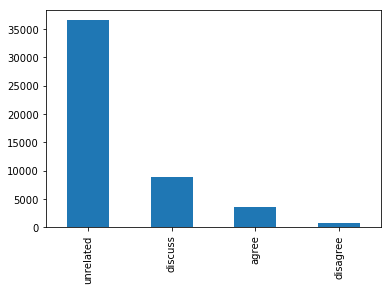

In [24]:
number_of_classes(train_heads)

           count  %counts
unrelated  18349     72.0
discuss     4464     18.0
agree       1903      7.0
disagree     697      3.0


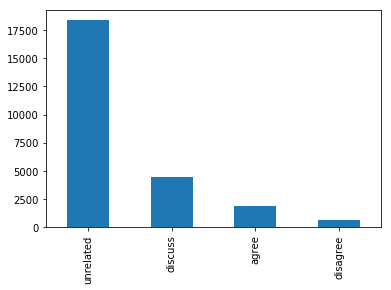

In [25]:
number_of_classes(test_heads)

# Data Processing

In [26]:
# Loading English stopwords
f = open('data\stopwords-en.txt', 'r')
english_stop_words = f.read().split('\n')
f.close()

In [27]:
# Initialising fuction for text processing (leaving only alphabetic characters, lowercase, removing stopwords)
def preprocessing(data, column):
    table = []
    table = [re.sub("[^a-zA-Z]", " ",str(a)) for a in data[column]]
    table = [word_tokenize(a) for a in table]
    table = [[w.lower() for w in a] for a in table]
    table = [[w for w in a if w not in english_stop_words] for a in table]
    table = [' '.join(x) for x in table]
    data[column] = table

In [28]:
# Initialising fuction for merging Headline and Article Body datasets
def merge_data(data1, data2, left_on=['Body ID'], right_on=['Body ID']):
    full_data = pd.merge(data1, data2,  how='inner', left_on=['Body ID'], right_on=['Body ID'])
    return full_data

In [29]:
# Initialising fuction for selecting unique headlines and article bodies
def get_unique_strings(dataframe, colname1='Headline', colname2='articleBody'):
    unique_strings = []
    for index, row in dataframe.iterrows():
        if row[colname1] not in unique_strings:
            unique_strings.append(row[colname1])
        if row[colname2] not in unique_strings:
            unique_strings.append(row[colname2])
    return unique_strings

In [30]:
# Counting total number of unique words
def number_of_uniqe_words(list_of_text):
    tokens = []
    for i in list_of_text:
        tokens.extend(word_tokenize(i))
    freq = FreqDist(tokens)
    number_of_words = len(freq)
    return number_of_words

In [31]:
# Initialising fuction for changing text to vectors
def process_data(unique_strings, n_words, dataframe):
    tfvectorizer = TfidfVectorizer(max_features=n_words, use_idf=False).fit(unique_strings)
    tfidfvectorizer = TfidfVectorizer(max_features=n_words, use_idf=True).fit(unique_strings)
    data = []
    for index, row in dataframe.iterrows():
        head = row['Headline']
        body = row['articleBody']
        head_tf = tfvectorizer.transform([head]).toarray().reshape(1, -1)
        body_tf = tfvectorizer.transform([body]).toarray().reshape(1, -1)
        head_tfidf = tfidfvectorizer.transform([head]).toarray()
        body_tfidf = tfidfvectorizer.transform([body]).toarray()
        tfidf_cos = cosine_similarity(head_tfidf, body_tfidf).reshape(1, -1)
        feat_vec = np.squeeze(np.c_[head_tf, body_tf, tfidf_cos])
        data.append(feat_vec)
    data = np.array(data)
    return data

In [32]:
pd.options.display.max_colwidth = 600

In [33]:
unprocessed_train = merge_data(train_heads, train_bodies)

In [34]:
# Example of unrelated class
unprocessed_train.loc[(unprocessed_train['Stance'] == 'unrelated') & (unprocessed_train['Body ID'] == 1403)]

,Headline,Body ID,Stance,articleBody
13581,"Apple Media Event Rumored for Late February, Apple Watch and 12"" MacBook Air Likely Topics [Updated]",1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13582,Attorney: New audio reveals pause in gunfire when Michael Brown was shot,1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13583,FBI Probing Alleged Audio of Michael Brown Shooting,1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13584,CNN Plays Alleged Audiotape of Michael Brown ShootingMilitarization Of Police,1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13585,"Audio captured at time of Michael Brown shooting, company says",1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13586,Audio recording allegedly captures moment Michael Brown was shot,1403,unrelated,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to st

In [35]:
# Example of agree class
unprocessed_train.loc[(unprocessed_train['Stance'] == 'agree') & (unprocessed_train['Body ID'] == 1403)]

,Headline,Body ID,Stance,articleBody
13598,Comcast Says You Can Keep Your Tor,1403,agree,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."


In [36]:
# Example of discuss class
unprocessed_train.loc[(unprocessed_train['Stance'] == 'discuss') & (unprocessed_train['Body ID'] == 1403)]

,Headline,Body ID,Stance,articleBody
13588,Comcast Declares War on Tor?,1403,discuss,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."


In [37]:
# Example of disagree class
unprocessed_train.loc[(unprocessed_train['Stance'] == 'disagree') & (unprocessed_train['Body ID'] == 1403)]

,Headline,Body ID,Stance,articleBody
13580,Comcast blocks Tor,1403,disagree,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."
13602,"Comcast Is Threatening To Cut Off Customers Who Use Tor, The Web Browser For Criminals",1403,disagree,"Reports that Comcast will deny Internet service to users of the Tor Internet browser are false, the company says in a new blog post. The browser lets users surf the web with a higher degree of anonymity, making it more difficult for hackers (or the government) to follow them around the Internet.\n\nComcast’s Jason Livingood wrote in today’s post:\n\nComcast is not asking customers to stop using Tor, or any other browser for that matter. We have no policy against Tor, or any other browser or software. Customers are free to use their Xfinity Internet service to visit any website, use any app..."


### Running functions in order to process text

In [38]:
preprocessing(train_heads, 'Headline')
preprocessing(train_bodies, 'articleBody')
preprocessing(test_heads, 'Headline')
preprocessing(test_bodies, 'articleBody')

In [39]:
train = merge_data(train_heads, train_bodies)
test = merge_data(test_heads, test_bodies)

In [40]:
unique_trains = get_unique_strings(train)

In [41]:
total_number_of_words = number_of_uniqe_words(unique_trains)

In [42]:
total_number_of_words

21634

In [43]:
X_train = process_data(unique_trains, 2000, train)
X_test = process_data(unique_trains, 2000, test)

In [44]:
print(X_train.shape)
print(X_test.shape)

(49972, 4001)
(25413, 4001)


In [45]:
y_train = train.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss' : 2, 'agree' : 3})
y_test = test.Stance.map({'unrelated': 0, 'disagree': 1, 'discuss' : 2, 'agree' : 3})

In [46]:
print(y_train.shape)
print(y_test.shape)

(49972,)
(25413,)


In [47]:
labels = [0, 1, 2, 3]

# Classification

In [48]:
def classification(class_model, name_of_model, **kwargs):
    model = class_model(**kwargs)
    name = name_of_model
    start_time = time.time()
    model.fit(X_train, y_train)
    time_of_fitting = round((time.time() - start_time) / 60, 2)
    print("Time of fitting: %s minutes" % (time_of_fitting))
    y_pred = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    f1_scores = metrics.f1_score(y_test, y_pred, labels=labels, average=None)
    f1_score_weighted = metrics.f1_score(y_test, y_pred, labels=labels, average='weighted')
    print(name)
    print('F1 score, class Unrelated: %.2f%%' % (f1_scores[0]*100),'\n'
          'F1 score, class Disagree: %.2f%%' % (f1_scores[1]*100),'\n'
          'F1 score, class Discuss: %.2f%%' % (f1_scores[2]*100),'\n'
          'F1 score, class Agree: %.2f%%' % (f1_scores[3]*100))
    print("F1 score weighted: %.2f%%" % (f1_score_weighted * 100.0))
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    list_of_models.append(name)
    F1_score_unrelated.append(f1_scores[0]*100)
    F1_score_disagree.append(f1_scores[1]*100)
    F1_score_discuss.append(f1_scores[2]*100)
    F1_score_agree.append(f1_scores[3]*100)
    F1_score_weighted_list.append(f1_score_weighted*100)
    accuracy_list.append(accuracy*100)
    times.append(time_of_fitting)

In [49]:
list_of_models = []
F1_score_unrelated = []
F1_score_disagree = []
F1_score_discuss = []
F1_score_agree = []
F1_score_weighted_list = []
accuracy_list = []
times = []

In [50]:
classification(DecisionTreeClassifier, 'Decision Tree')

Time of fitting: 5.31 minutes
Decision Tree
F1 score, class Unrelated: 91.32% 
F1 score, class Disagree: 5.71% 
F1 score, class Discuss: 57.26% 
F1 score, class Agree: 37.31%
F1 score weighted: 78.95%
Accuracy: 79.16%


In [51]:
classification(RandomForestClassifier, 'Random Forest')

Time of fitting: 0.55 minutes
Random Forest
F1 score, class Unrelated: 93.85% 
F1 score, class Disagree: 0.00% 
F1 score, class Discuss: 61.08% 
F1 score, class Agree: 37.20%
F1 score weighted: 81.28%
Accuracy: 83.07%


In [52]:
classification(LogisticRegression, 'Logistic Regression', solver='saga', multi_class='multinomial')

Time of fitting: 2.87 minutes
Logistic Regression
F1 score, class Unrelated: 93.97% 
F1 score, class Disagree: 0.86% 
F1 score, class Discuss: 67.07% 
F1 score, class Agree: 44.76%
F1 score weighted: 83.01%
Accuracy: 84.96%


In [53]:
classification(QuadraticDiscriminantAnalysis, 'QDA')

C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Time of fitting: 6.72 minutes
QDA
F1 score, class Unrelated: 4.75% 
F1 score, class Disagree: 4.86% 
F1 score, class Discuss: 24.44% 
F1 score, class Agree: 0.82%
F1 score weighted: 7.91%
Accuracy: 9.22%


In [54]:
classification(ExtraTreeClassifier, 'Extra Tree Classifier')

Time of fitting: 0.58 minutes
Extra Tree Classifier
F1 score, class Unrelated: 85.82% 
F1 score, class Disagree: 7.25% 
F1 score, class Discuss: 46.27% 
F1 score, class Agree: 30.87%
F1 score weighted: 72.60%
Accuracy: 71.32%


In [55]:
classification(LinearSVC, 'LinearSVC', multi_class='crammer_singer')

Time of fitting: 0.85 minutes
LinearSVC
F1 score, class Unrelated: 92.19% 
F1 score, class Disagree: 4.99% 
F1 score, class Discuss: 61.41% 
F1 score, class Agree: 42.50%
F1 score weighted: 80.67%
Accuracy: 81.63%


In [56]:
classification(BernoulliNB, 'Bernoulli NB')

Time of fitting: 0.46 minutes
Bernoulli NB
F1 score, class Unrelated: 77.48% 
F1 score, class Disagree: 4.48% 
F1 score, class Discuss: 25.17% 
F1 score, class Agree: 33.38%
F1 score weighted: 62.99%
Accuracy: 61.96%


In [57]:
classification(GaussianNB, 'Gaussian NB')

Time of fitting: 0.13 minutes
Gaussian NB
F1 score, class Unrelated: 22.15% 
F1 score, class Disagree: 10.12% 
F1 score, class Discuss: 28.73% 
F1 score, class Agree: 14.93%
F1 score weighted: 22.43%
Accuracy: 21.26%


In [58]:
summary_dict = {'model' : list_of_models, 
                'F1 score, class Unrelated' : F1_score_unrelated, 
                'F1 score, class Disagree' : F1_score_disagree, 
                'F1 score, class Discuss' : F1_score_discuss, 
                'F1 score, class Agree' : F1_score_agree, 
                'F1 score weighted' : F1_score_weighted_list,
                'Accuracy' : accuracy_list, 
                'Time of fitting (in minutes)' : times}

In [59]:
summary_table = pd.DataFrame(summary_dict)

In [60]:
summary_table.set_index('model', inplace=True)
summary_table.index.name = None

In [61]:
summary_table

,Accuracy,F1 score weighted,"F1 score, class Agree","F1 score, class Disagree","F1 score, class Discuss","F1 score, class Unrelated",Time of fitting (in minutes)
Decision Tree,79.164207,78.947653,37.313041,5.708849,57.257638,91.324476,5.31
Random Forest,83.071656,81.276276,37.198489,0.000000,61.080032,93.848385,0.55
Logistic Regression,84.964388,83.007402,44.759891,0.855920,67.065026,93.973197,2.87
QDA,9.219691,7.914609,0.821777,4.864328,24.439746,4.745799,6.72
Extra Tree Classifier,71.321764,72.602009,30.872202,7.253886,46.271473,85.817933,0.58
LinearSVC,81.627513,80.673364,42.504849,4.986877,61.409999,92.193329,0.85
Bernoulli NB,61.964349,62.987773,33.375675,4.481793,25.169246,77.481881,0.46
Gaussian NB,21.256837,22.433639,14.930191,10.123796,28.734168,22.146619,0.13


In [62]:
models = [LogisticRegression(solver='saga', multi_class='multinomial'), 
          LinearSVC(multi_class='crammer_singer'),
          DecisionTreeClassifier(),
          ExtraTreeClassifier()]

model = VotingClassifier(estimators=list(zip(["lr","lsvc","dtr",'exc'],models)),voting="hard")
name = 'Voting Classifier'
start_time = time.time()
model.fit(X_train, y_train)
time_of_model = round((time.time() - start_time) / 60, 2)
print("Time of fitting: %s minutes" % (time_of_model))
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
f1_scores = metrics.f1_score(y_test, y_pred, labels=labels, average=None)
f1_score_weighted = metrics.f1_score(y_test, y_pred, labels=labels, average='weighted')
print('F1 score, class Unrelated: %.2f%%' % (f1_scores[0]*100),'\n'
     'F1 score, class Disagree: %.2f%%' % (f1_scores[1]*100),'\n'
     'F1 score, class Discuss: %.2f%%' % (f1_scores[2]*100),'\n'
     'F1 score, class Agree: %.2f%%' % (f1_scores[3]*100))
print("F1 score weighted: %.2f%%" % (f1_score_weighted * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

list_of_models.append(name)
F1_score_unrelated.append(f1_scores[0]*100)
F1_score_disagree.append(f1_scores[1]*100)
F1_score_discuss.append(f1_scores[2]*100)
F1_score_agree.append(f1_scores[3]*100)
F1_score_weighted_list.append(f1_score_weighted*100)
accuracy_list.append(accuracy*100)
times.append(time_of_model)

Time of fitting: 9.46 minutes
F1 score, class Unrelated: 93.98% 
F1 score, class Disagree: 2.43% 
F1 score, class Discuss: 66.27% 
F1 score, class Agree: 39.19%
F1 score weighted: 82.50%
Accuracy: 84.59%


In [63]:
best_params = []

models = [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=500), 
          LinearSVC(multi_class='crammer_singer'),
          DecisionTreeClassifier(),
          ExtraTreeClassifier()]

param_grids = [{"penalty":["l1","l2"], "C":[0.5,1,3]},
               {"penalty":["l1","l2"], "C":[0.5,1,3]},
               {"criterion": ['gini', 'entropy'], "min_samples_leaf": [1,5,10]},
               {"criterion": ['gini', 'entropy'], "min_samples_leaf": [1,5,10]}]

for model, grid in zip(models,param_grids):
    start_time = time.time()
    print(model)
    cv = GridSearchCV(model,grid,scoring="f1_weighted")
    cv.fit(X_train,y_train)
    time_of_model = round((time.time() - start_time) / 60, 2)
    print("Time of modeling: %s minutes" % (time_of_model))
    best_params.append(cv.best_params_)
    pprint(cv.grid_scores_)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)


C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Time of modeling: 389.9 minutes


C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.90459, std: 0.00506, params: {'C': 0.5, 'penalty': 'l1'},
 mean: 0.90873, std: 0.00443, params: {'C': 0.5, 'penalty': 'l2'},
 mean: 0.90652, std: 0.00560, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.91096, std: 0.00309, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.90053, std: 0.00427, params: {'C': 3, 'penalty': 'l1'},
 mean: 0.90960, std: 0.00225, params: {'C': 3, 'penalty': 'l2'}]
LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='crammer_singer', penalty='l2', random_state=None,
     tol=0.0001, verbose=0)
Time of modeling: 23.62 minutes
[mean: 0.90875, std: 0.00132, params: {'C': 0.5, 'penalty': 'l1'},
 mean: 0.90875, std: 0.00132, params: {'C': 0.5, 'penalty': 'l2'},
 mean: 0.90274, std: 0.00291, params: {'C': 1, 'penalty': 'l1'},
 mean: 0.90274, std: 0.00292, params: {'C': 1, 'penalty': 'l2'},
 mean: 0.89329, std: 0.00299, params: {'C': 3, 'penalty': 'l1'},
 mean: 0.89329, std

C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Time of modeling: 43.24 minutes
[mean: 0.80321, std: 0.02667, params: {'criterion': 'gini', 'min_samples_leaf': 1},
 mean: 0.85818, std: 0.00403, params: {'criterion': 'gini', 'min_samples_leaf': 5},
 mean: 0.86961, std: 0.00664, params: {'criterion': 'gini', 'min_samples_leaf': 10},
 mean: 0.84684, std: 0.01707, params: {'criterion': 'entropy', 'min_samples_leaf': 1},
 mean: 0.86804, std: 0.00897, params: {'criterion': 'entropy', 'min_samples_leaf': 5},
 mean: 0.88095, std: 0.00300, params: {'criterion': 'entropy', 'min_samples_leaf': 10}]
ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random')


C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Time of modeling: 1.89 minutes
[mean: 0.57776, std: 0.05204, params: {'criterion': 'gini', 'min_samples_leaf': 1},
 

C:\Users\Lukasz1\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


mean: 0.66158, std: 0.09710, params: {'criterion': 'gini', 'min_samples_leaf': 5},
 mean: 0.68044, std: 0.06545, params: {'criterion': 'gini', 'min_samples_leaf': 10},
 mean: 0.61419, std: 0.06358, params: {'criterion': 'entropy', 'min_samples_leaf': 1},
 mean: 0.58481, std: 0.02363, params: {'criterion': 'entropy', 'min_samples_leaf': 5},
 mean: 0.66811, std: 0.05636, params: {'criterion': 'entropy', 'min_samples_leaf': 10}]


In [69]:
classification(LinearSVC, 'Linear SVC (optimised)', multi_class='crammer_singer', C=0.5)

Time of fitting: 0.33 minutes
Linear SVC (optimised)
F1 score, class Unrelated: 92.88% 
F1 score, class Disagree: 3.97% 
F1 score, class Discuss: 63.60% 
F1 score, class Agree: 44.27%
F1 score weighted: 81.66%
Accuracy: 82.96%


In [70]:
classification(DecisionTreeClassifier, 'Decision Tree (optimised)', criterion='entropy', min_samples_leaf=10)

Time of fitting: 3.61 minutes
Decision Tree (optimised)
F1 score, class Unrelated: 93.98% 
F1 score, class Disagree: 15.88% 
F1 score, class Discuss: 61.65% 
F1 score, class Agree: 38.73%
F1 score weighted: 82.02%
Accuracy: 83.11%


In [71]:
classification(ExtraTreeClassifier, 'Extra Tree (optimised)', criterion='gini', min_samples_leaf=10)

Time of fitting: 0.21 minutes
Extra Tree (optimised)
F1 score, class Unrelated: 89.99% 
F1 score, class Disagree: 1.28% 
F1 score, class Discuss: 54.63% 
F1 score, class Agree: 34.88%
F1 score weighted: 77.22%
Accuracy: 77.69%


In [72]:
classification(LogisticRegression, 'Logistic Regression (optimised)', solver='saga', multi_class='multinomial', max_iter=500, penalty='l2')

Time of fitting: 3.25 minutes
Logistic Regression (optimised)
F1 score, class Unrelated: 93.97% 
F1 score, class Disagree: 0.86% 
F1 score, class Discuss: 67.07% 
F1 score, class Agree: 44.76%
F1 score weighted: 83.01%
Accuracy: 84.96%


In [73]:
models = [LogisticRegression(solver='saga', multi_class='multinomial', max_iter=500, penalty='l2'), 
          LinearSVC(multi_class='crammer_singer', C=0.5),
          DecisionTreeClassifier(criterion='entropy', min_samples_leaf=10),
          ExtraTreeClassifier(criterion='gini', min_samples_leaf=10)]

model = VotingClassifier(estimators=list(zip(["lr","lsvc","dtr",'exc'],models)),voting="hard")
name = 'Voting Classifier (optimised)'
start_time = time.time()
model.fit(X_train, y_train)
time_of_model = round((time.time() - start_time) / 60, 2)
print("Time of fitting: %s minutes" % (time_of_model))
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
f1_scores = metrics.f1_score(y_test, y_pred, labels=labels, average=None)
f1_score_weighted = metrics.f1_score(y_test, y_pred, labels=labels, average='weighted')
print('F1 score, class Unrelated: %.2f%%' % (f1_scores[0]*100),'\n'
     'F1 score, class Disagree: %.2f%%' % (f1_scores[1]*100),'\n'
     'F1 score, class Discuss: %.2f%%' % (f1_scores[2]*100),'\n'
     'F1 score, class Agree: %.2f%%' % (f1_scores[3]*100))
print("F1 score weighted: %.2f%%" % (f1_score_weighted * 100.0))
print("Accuracy: %.2f%%" % (accuracy * 100.0))
list_of_models.append(name)
F1_score_unrelated.append(f1_scores[0]*100)
F1_score_disagree.append(f1_scores[1]*100)
F1_score_discuss.append(f1_scores[2]*100)
F1_score_agree.append(f1_scores[3]*100)
F1_score_weighted_list.append(f1_score_weighted*100)
accuracy_list.append(accuracy*100)
times.append(time_of_model)

Time of fitting: 7.11 minutes
F1 score, class Unrelated: 93.83% 
F1 score, class Disagree: 2.52% 
F1 score, class Discuss: 66.92% 
F1 score, class Agree: 43.38%
F1 score weighted: 82.82%
Accuracy: 84.91%


In [74]:
summary_dict = {'model' : list_of_models, 
                'F1 score, class Unrelated' : F1_score_unrelated, 
                'F1 score, class Disagree' : F1_score_disagree, 
                'F1 score, class Discuss' : F1_score_discuss, 
                'F1 score, class Agree' : F1_score_agree, 
                'F1 score weighted' : F1_score_weighted_list,
                'Accuracy' : accuracy_list, 
                'Time of fitting (in minutes)' : times}

In [75]:
summary_table = pd.DataFrame(summary_dict)

In [76]:
summary_table.set_index('model', inplace=True)
summary_table.index.name = None

In [77]:
summary_table

,Accuracy,F1 score weighted,"F1 score, class Agree","F1 score, class Disagree","F1 score, class Discuss","F1 score, class Unrelated",Time of fitting (in minutes)
Decision Tree,79.164207,78.947653,37.313041,5.708849,57.257638,91.324476,5.31
Random Forest,83.071656,81.276276,37.198489,0.000000,61.080032,93.848385,0.55
Logistic Regression,84.964388,83.007402,44.759891,0.855920,67.065026,93.973197,2.87
QDA,9.219691,7.914609,0.821777,4.864328,24.439746,4.745799,6.72
Extra Tree Classifier,71.321764,72.602009,30.872202,7.253886,46.271473,85.817933,0.58
LinearSVC,81.627513,80.673364,42.504849,4.986877,61.409999,92.193329,0.85
Bernoulli NB,61.964349,62.987773,33.375675,4.481793,25.169246,77.481881,0.46
Gaussian NB,21.256837,22.433639,14.930191,10.123796,28.734168,22.146619,0.13
Voting Classifier,84.586629,82.496294,39.190981,2.425876,66.265607,93.977730,9.46
Linear SVC (optimised),82.961476,81.660506,44.274360,3.973510,63.602110,92.882172,0.33


In [78]:
summary_table.sort_values(['F1 score weighted'], ascending=False)

,Accuracy,F1 score weighted,"F1 score, class Agree","F1 score, class Disagree","F1 score, class Discuss","F1 score, class Unrelated",Time of fitting (in minutes)
Logistic Regression,84.964388,83.007402,44.759891,0.855920,67.065026,93.973197,2.87
Logistic Regression (optimised),84.964388,83.007402,44.759891,0.855920,67.065026,93.973197,3.25
Voting Classifier (optimised),84.909298,82.823224,43.381180,2.517483,66.923977,93.832301,7.11
Voting Classifier,84.586629,82.496294,39.190981,2.425876,66.265607,93.977730,9.46
Decision Tree (optimised),83.107071,82.020777,38.730159,15.876289,61.647967,93.979411,3.61
Linear SVC (optimised),82.961476,81.660506,44.274360,3.973510,63.602110,92.882172,0.33
Random Forest,83.071656,81.276276,37.198489,0.000000,61.080032,93.848385,0.55
LinearSVC,81.627513,80.673364,42.504849,4.986877,61.409999,92.193329,0.85
Decision Tree,79.164207,78.947653,37.313041,5.708849,57.257638,91.324476,5.31
Extra Tree (optimised),77.688585,77.219486,34.884814,1.275510,54.633502,89.989646,0.21
